This dataset is from Global Terrorism Database curated by the University of Maryland:

National Consortium for the Study of Terrorism and Responses to Terrorism (START). (2018). Global Terrorism Database [Data file]. Retrieved from https://www.start.umd.edu/gtd.

In dividing and classifying the city names within the data-set, __[this article from the New York Times](https://www.nytimes.com/interactive/2016/01/04/world/middleeast/sunni-shiite-map-middle-east-iran-saudi-arabia.html)__ was instrumental as was __[this website](http://zakhor-online.com/?attachment_id=7932)__ and __[this one.](https://www.vox.com/a/maps-explain-the-middle-east)__
__[and this one too](http://gulf2000.columbia.edu/maps.shtml)__ https://www.crisisgroup.org/latin-america-caribbean/andes/colombia/63-colombias-armed-groups-battle-spoils-peace#map-5700-8

In this notebook, we will try and isolate data related to cyber-warfare or hacking events.

In [67]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

### 1. Importing, Cleaning and General Overview:

#### A. Importing Data.

In [2]:
df = pd.read_excel('globalterrorismdb_0718dist.xlsx', 
                   usecols = 'A:D, F, H:M, S:W, AA:AD, AI:AN, AP, BG, BM:BN, BQ:BR, CD:CG, DA',
                   dtype = {'summary':str, 'motive':str})                                                                                         

In [3]:
# Renaming for usability:

cyber_data = pd.DataFrame(df.rename({'eventid':'event_id', 'iyear':'year', 'imonth':'month',
             'iday':'day', 'extended':'24+hrs', 'provstate':'region_2', 'doubtterr':'doubt', 
             'attacktype1':'attack_1', 'attacktype1_txt':'attack_1txt','attacktype2':'attack_2', 
             'targtype1':'target_1', 'targtype1_txt':'target_1txt', 'targsubtype1':'sub_target',
             'targsubtype1_txt':'sub_targettxt', 'target1':'specific_target',
             'natlty1':'victim_nationality', 'natlty1_txt':'victim_nationalitytxt', 'gname':'group_name', 
             'guncertain1':'group_attrib_crtainty', 'individual':'unaffil_individ', 'weaptype1':'weapon', 
             'weaptype1_txt':'weapontxt', 'weapsubtype1':'sub_weapon', 'weapsubtype1_txt':'sub_weapontxt'}, axis = 1))

#### B. Selecting Rows Specific to Our Question (cyber_data):


In [4]:
# Creating the dyber_cyber_train_input Dataframe:
# Regex to isolate qualifying data (This set is more flexible in its Regex):
import re
import gc

print(cyber_data.summary.str.contains('cyb+|social|inform+|network+|twit+|facebook|fake|electio+|internet|ads|adv+|priv+|hac+|breac+|emai+',
                         flags = re.IGNORECASE, regex = True).value_counts())

# Creating a mask which represents the results from our search above:

mask = cyber_data.summary.str.contains(r'(cyb+|social|inform+|network+|twit+|facebook|fake|electio+|internet|ads|adv+|priv+|hac+|breac+|emai+)', 
                           flags = re.IGNORECASE)

# Creating a new, filtered dataframe with this specific information:

cyber_data = pd.DataFrame(cyber_data[mask])

False    172205
True       9486
Name: summary, dtype: int64


#### C. Splitting Our Train/Test Data (cyber_train/test_input / cyber_train/test_output):

In [5]:
from sklearn.model_selection import cross_val_score, train_test_split

In [6]:
# Defining our Input and Output:
# Cleaning later to prevent leakage.

X = cyber_data.drop(['event_id', 'success', 'summary', 'motive'], axis = 1)
Y = pd.DataFrame(cyber_data['success'])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .25)

X_train_start_index = X_train.index
X_test_start_index = X_test.index
Y_train_start_index = Y_train.index
Y_test_start_index = Y_test.index

#### D. Isolating Columns:

> We want to be sure we are only using the numeric columns that are significant and not arbitrary categoricals:

In [7]:
# Dropping irrelevant columns from training set input and putting it into a datafarme:

cyber_train_input = X_train[['24+hrs', 'country_txt', 'region_txt', 'city', 'crit1', 'crit2', 'crit3',
                             'doubt', 'suicide', 'attack_1txt', 'target_1txt', 'sub_targettxt', 
                             'specific_target', 'victim_nationalitytxt', 'group_name', 'group_attrib_crtainty', 
                             'unaffil_individ', 'weapontxt', 'sub_weapontxt']]

# Making sure these dropped rows are not in the training output column (i.e. making sure our input and output cyber_train_inputs
# have the same amount of rows):

cyber_train_input_index = cyber_train_input.index

cyber_train_output = Y_train.iloc[Y_train.index == cyber_train_input_index]

In [8]:
# Applying the same process above to our test data:

cyber_test_input = X_test[['24+hrs', 'country_txt', 'region_txt', 'city', 'crit1', 'crit2', 'crit3',
                             'doubt', 'suicide', 'attack_1txt', 'target_1txt', 'sub_targettxt', 
                             'specific_target', 'victim_nationalitytxt', 'group_name', 'group_attrib_crtainty', 
                             'unaffil_individ', 'weapontxt', 'sub_weapontxt']]

# Making sure these dropped rows are not in the testing output column (i.e. making sure our input and output cyber_test_inputs
# have the same amount of rows):

cyber_test_input_index = cyber_test_input.index

cyber_test_output = Y_test.iloc[Y_test.index == cyber_test_input_index]

#### E. Applying Filters to Text Columns.

> Doing this mainly in the hopes of allowing us to get dummies on certain features which is small enough to use for explanatory purposes (i.e. avoiding a feature set with thousands of columns).

##### Weapontxt:

> ###### Training Input:

In [9]:
# Grouping Biological and Chemical Weapons:
cyber_train_input['weapontxt'] = cyber_train_input['weapontxt'].replace('Chemical', 'Bio-Chem')
cyber_train_input['weapontxt'] = cyber_train_input['weapontxt'].replace('Biological', 'Bio-Chem')

# Grouping Fake and Other together:
cyber_train_input['weapontxt'] = cyber_train_input['weapontxt'].replace('Fake Weapons', 'Fake/Other')
cyber_train_input['weapontxt'] = cyber_train_input['weapontxt'].replace('Other', 'Fake/Other')

# Aggregating Vehicle into Sabotage Equipment:
cyber_train_input['weapontxt'] = cyber_train_input['weapontxt'].replace(
    'Vehicle (not to include vehicle-borne explosives, i.e., car or truck bombs)', 'Sabotage Equipment')


> ###### Test Input:

In [10]:
# Grouping Biological and Chemical Weapons:
cyber_test_input['weapontxt'] = cyber_test_input['weapontxt'].replace('Chemical', 'Bio-Chem')
cyber_test_input['weapontxt'] = cyber_test_input['weapontxt'].replace('Biological', 'Bio-Chem')

# Grouping Fake and Other together:
cyber_test_input['weapontxt'] = cyber_test_input['weapontxt'].replace('Fake Weapons', 'Fake/Other')
cyber_test_input['weapontxt'] = cyber_test_input['weapontxt'].replace('Other', 'Fake/Other')

# Aggregating Vehicle into Sabotage Equipment:
cyber_test_input['weapontxt'] = cyber_test_input['weapontxt'].replace(
    'Vehicle (not to include vehicle-borne explosives, i.e., car or truck bombs)', 'Sabotage Equipment')


##### Sub_targettxt:

> ###### Training Input:

In [11]:
industrial = ['Gas/Oil/Electric', 'Industrial/Textiles/Factory', 'Farm/Ranch', 'Mining', 'Construction']
cyber_train_input['sub_targettxt'] = cyber_train_input['sub_targettxt'].where(
                                     cyber_train_input['sub_targettxt'].apply(lambda x: x not in industrial), 
                                     other = 'Industrial')


white_collar = ['Restaurant/Bar/Café', 'Bank/Commerce', 'Multinational Corporation', 
                'Medical/Pharmaceutical', 'Retail/Grocery/Bakery (including cell phone shops and generic shops)', 
                'Hotel/Resort', 'Entertainment/Cultural/Stadium/Casino', 'Private Security Company/Firm',
                'Legal Services']
cyber_train_input['sub_targettxt'] = cyber_train_input['sub_targettxt'].where(
                                     cyber_train_input['sub_targettxt'].apply(lambda x: x not in white_collar), 
                                     other = 'White_Collar')


gov_figure1 = ['Judges/Attorneys/Courts', 'Government Personnel (excluding police, military)']
cyber_train_input['sub_targettxt'] = cyber_train_input['sub_targettxt'].where(
                                     cyber_train_input['sub_targettxt'].apply(lambda x: x not in gov_figure1), 
                                     other = 'Gov_Figure1')

gov_figure2 = ['Politician or Political Party Movement/Meeting/Rally', 'Royalty', 'Head of State',
               'Election-Related']
cyber_train_input['sub_targettxt'] = cyber_train_input['sub_targettxt'].where(
                                     cyber_train_input['sub_targettxt'].apply(lambda x: x not in gov_figure2), 
                                     other = 'Gov_Figure2')


police_facilities = ['Police Buildings (Headquarters/Stations/School)', 
                     'Police Patrol (including vehicles and convoys)', 
                     'Police Checkpoint', 'Prison/Jail']
cyber_train_input['sub_targettxt'] = cyber_train_input['sub_targettxt'].where(
                                     cyber_train_input['sub_targettxt'].apply(lambda x: x not in gov_figure2), 
                                     other = 'Police_Facilities')

military_facilities = ['Military Barracks/Base/Headquarters/Checkpost', 'Military Recruiting Station/Academy',
                       'Military Weaponry', 'Military Aircraft', 'Military Maritime', 
                       'Military Transportation/Vehicle (excluding convoys)', 'Military Checkpoint',
                       'Paramilitary']
cyber_train_input['sub_targettxt'] = cyber_train_input['sub_targettxt'].where(
                                     cyber_train_input['sub_targettxt'].apply(lambda x: x not in military_facilities), 
                                     other = 'Military_Facilities')


military_personnel = ['Military Unit/Patrol/Convoy', 'Non-combatant Personnel', 
                      'Military Personnel (soldiers, troops, officers, forces)']
cyber_train_input['sub_targettxt'] = cyber_train_input['sub_targettxt'].where(
                                     cyber_train_input['sub_targettxt'].apply(lambda x: x not in military_personnel), 
                                     other = 'Military_Personnel')


pilots_aircraft = ['Aircraft (not at an airport)', 'Airline Officer/Personnel']
cyber_train_input['sub_targettxt'] = cyber_train_input['sub_targettxt'].where(
                                     cyber_train_input['sub_targettxt'].apply(lambda x: x not in military_personnel), 
                                     other = 'Pilots_Aircraft')

gov_diplomatic = [' Diplomatic Personnel (outside of embassy, consulate)', 'Embassy/Consulate', 
                  'International Organization (peacekeeper, aid agency, compound)']
cyber_train_input['sub_targettxt'] = cyber_train_input['sub_targettxt'].where(
                                     cyber_train_input['sub_targettxt'].apply(lambda x: x not in gov_diplomatic), 
                                     other = 'Gov_Diplomatic')

educational = ['Teacher/Professor/Instructor', 'School/University/Educational Building', 
               'Other Personnel']
cyber_train_input['sub_targettxt'] = cyber_train_input['sub_targettxt'].where(
                                     cyber_train_input['sub_targettxt'].apply(lambda x: x not in educational), 
                                     other = 'Educational')

food_water = ['Food Supply', 'Water Supply']
cyber_train_input['sub_targettxt'] = cyber_train_input['sub_targettxt'].where(
                                     cyber_train_input['sub_targettxt'].apply(lambda x: x not in food_water), 
                                     other = 'Food_Water')

media = ['Newspaper Journalist/Staff/Facility', 'Radio Journalist/Staff/Facility', 
         'Television Journalist/Staff/Facility', 'Other (including online news agencies)']
cyber_train_input['sub_targettxt'] = cyber_train_input['sub_targettxt'].where(
                                     cyber_train_input['sub_targettxt'].apply(lambda x: x not in media), 
                                     other = 'Media')


religious = ['Religion Identified', 'Religious Figure', 'Place of Worship', 
             'Affiliated Institution']
cyber_train_input['sub_targettxt'] = cyber_train_input['sub_targettxt'].where(
                                     cyber_train_input['sub_targettxt'].apply(lambda x: x not in military_personnel), 
                                     other = 'Pilots_Aircraft')


political = ['Protrainer', 'Political Party Member/Rally', 'Party Official/Candidate/Other Personnel', 
             'Party Office/Facility', 'Rally']
cyber_train_input['sub_targettxt'] = cyber_train_input['sub_targettxt'].where(
                                     cyber_train_input['sub_targettxt'].apply(lambda x: x not in political), 
                                     other = 'Political')

mass_socio = ['Refugee (including Camps/IDP/Asylum Seekers)', 'Named Civilian', 'Student', 
              'Race/Ethnicity Identified', 'Farmer', 'Vehicles/Transportation', 'Marketplace/Plaza/Square', 'Village/City/Town/Suburb', 
              'House/Apartment/Residence', 'Laborer (General)/Occupation Identified', 'Procession/Gathering (funeral, wedding, birthday, religious)', 
              'Public Areas (e.g., Public garden, parking lot, garage, beach, public buildings, camps)',
             'Memorial/Cemetery/Monument', 'Museum/Cultural Center/Cultural House', 'Labor Union Related', 
              'Tourism Travel Agency', 'Tour Bus/Van/Vehicle', 'Tourist', 'Other Facility', 'train/train Tracks/ Trolley', 'Bus Station/Stop', 'Subway', 
              'Bridge/Car Tunnel', 'Highway/Road/Toll/Traffic Signal', 'Taxi/Rickshaw']
cyber_train_input['sub_targettxt'] = cyber_train_input['sub_targettxt'].where(
                                     cyber_train_input['sub_targettxt'].apply(lambda x: x not in mass_socio), 
                                     other = 'Mass_Social')



util_telecom = ['Radio', 'Television', 'Telephone/Telegraph', 'Internet Infrastructure', 
                'Multiple Telecommunication Targets', 'Gas', 'Electricity', 'Oil']
cyber_train_input['sub_targettxt'] = cyber_train_input['sub_targettxt'].where(
                                     cyber_train_input['sub_targettxt'].apply(lambda x: x not in util_telecom), 
                                     other = 'Util_Telecom')

> ###### Test Input:

In [12]:
# Test Input:

industrial = ['Gas/Oil/Electric', 'Industrial/Textiles/Factory', 'Farm/Ranch', 'Mining', 'Construction']
cyber_test_input['sub_targettxt'] = cyber_test_input['sub_targettxt'].where(
                                     cyber_test_input['sub_targettxt'].apply(lambda x: x not in industrial), 
                                     other = 'Industrial')


white_collar = ['Restaurant/Bar/Café', 'Bank/Commerce', 'Multinational Corporation', 
                'Medical/Pharmaceutical', 'Retail/Grocery/Bakery (including cell phone shops and generic shops)', 
                'Hotel/Resort', 'Entertainment/Cultural/Stadium/Casino', 'Private Security Company/Firm',
                'Legal Services']
cyber_test_input['sub_targettxt'] = cyber_test_input['sub_targettxt'].where(
                                     cyber_test_input['sub_targettxt'].apply(lambda x: x not in white_collar), 
                                     other = 'White_Collar')


gov_figure1 = ['Judges/Attorneys/Courts', 'Government Personnel (excluding police, military)']
cyber_test_input['sub_targettxt'] = cyber_test_input['sub_targettxt'].where(
                                     cyber_test_input['sub_targettxt'].apply(lambda x: x not in gov_figure1), 
                                     other = 'Gov_Figure1')

gov_figure2 = ['Politician or Political Party Movement/Meeting/Rally', 'Royalty', 'Head of State',
               'Election-Related']
cyber_test_input['sub_targettxt'] = cyber_test_input['sub_targettxt'].where(
                                     cyber_test_input['sub_targettxt'].apply(lambda x: x not in gov_figure2), 
                                     other = 'Gov_Figure2')


police_facilities = ['Police Buildings (Headquarters/Stations/School)', 
                     'Police Patrol (including vehicles and convoys)', 
                     'Police Checkpoint', 'Prison/Jail']
cyber_test_input['sub_targettxt'] = cyber_test_input['sub_targettxt'].where(
                                     cyber_test_input['sub_targettxt'].apply(lambda x: x not in gov_figure2), 
                                     other = 'Police_Facilities')

military_facilities = ['Military Barracks/Base/Headquarters/Checkpost', 'Military Recruiting Station/Academy',
                       'Military Weaponry', 'Military Aircraft', 'Military Maritime', 
                       'Military Transportation/Vehicle (excluding convoys)', 'Military Checkpoint',
                       'Paramilitary']
cyber_test_input['sub_targettxt'] = cyber_test_input['sub_targettxt'].where(
                                     cyber_test_input['sub_targettxt'].apply(lambda x: x not in military_facilities), 
                                     other = 'Military_Facilities')


military_personnel = ['Military Unit/Patrol/Convoy', 'Non-combatant Personnel', 
                      'Military Personnel (soldiers, troops, officers, forces)']
cyber_test_input['sub_targettxt'] = cyber_test_input['sub_targettxt'].where(
                                     cyber_test_input['sub_targettxt'].apply(lambda x: x not in military_personnel), 
                                     other = 'Military_Personnel')


pilots_aircraft = ['Aircraft (not at an airport)', 'Airline Officer/Personnel']
cyber_test_input['sub_targettxt'] = cyber_test_input['sub_targettxt'].where(
                                     cyber_test_input['sub_targettxt'].apply(lambda x: x not in military_personnel), 
                                     other = 'Pilots_Aircraft')

gov_diplomatic = [' Diplomatic Personnel (outside of embassy, consulate)', 'Embassy/Consulate', 
                  'International Organization (peacekeeper, aid agency, compound)']
cyber_test_input['sub_targettxt'] = cyber_test_input['sub_targettxt'].where(
                                     cyber_test_input['sub_targettxt'].apply(lambda x: x not in gov_diplomatic), 
                                     other = 'Gov_Diplomatic')

educational = ['Teacher/Professor/Instructor', 'School/University/Educational Building', 
               'Other Personnel']
cyber_test_input['sub_targettxt'] = cyber_test_input['sub_targettxt'].where(
                                     cyber_test_input['sub_targettxt'].apply(lambda x: x not in educational), 
                                     other = 'Educational')

food_water = ['Food Supply', 'Water Supply']
cyber_test_input['sub_targettxt'] = cyber_test_input['sub_targettxt'].where(
                                     cyber_test_input['sub_targettxt'].apply(lambda x: x not in food_water), 
                                     other = 'Food_Water')

media = ['Newspaper Journalist/Staff/Facility', 'Radio Journalist/Staff/Facility', 
         'Television Journalist/Staff/Facility', 'Other (including online news agencies)']
cyber_test_input['sub_targettxt'] = cyber_test_input['sub_targettxt'].where(
                                     cyber_test_input['sub_targettxt'].apply(lambda x: x not in media), 
                                     other = 'Media')


religious = ['Religion Identified', 'Religious Figure', 'Place of Worship', 
             'Affiliated Institution']
cyber_test_input['sub_targettxt'] = cyber_test_input['sub_targettxt'].where(
                                     cyber_test_input['sub_targettxt'].apply(lambda x: x not in military_personnel), 
                                     other = 'Pilots_Aircraft')


political = ['Protester', 'Political Party Member/Rally', 'Party Official/Candidate/Other Personnel', 
             'Party Office/Facility', 'Rally']
cyber_test_input['sub_targettxt'] = cyber_test_input['sub_targettxt'].where(
                                     cyber_test_input['sub_targettxt'].apply(lambda x: x not in political), 
                                     other = 'Political')

mass_socio = ['Refugee (including Camps/IDP/Asylum Seekers)', 'Named Civilian', 'Student', 
              'Race/Ethnicity Identified', 'Farmer', 'Vehicles/Transportation', 'Marketplace/Plaza/Square', 'Village/City/Town/Suburb', 
              'House/Apartment/Residence', 'Laborer (General)/Occupation Identified', 'Procession/Gathering (funeral, wedding, birthday, religious)', 
              'Public Areas (e.g., Public garden, parking lot, garage, beach, public buildings, camps)',
             'Memorial/Cemetery/Monument', 'Museum/Cultural Center/Cultural House', 'Labor Union Related', 
              'Tourism Travel Agency', 'Tour Bus/Van/Vehicle', 'Tourist', 'Other Facility', 'test/test Tracks/ Trolley', 'Bus Station/Stop', 'Subway', 
              'Bridge/Car Tunnel', 'Highway/Road/Toll/Traffic Signal', 'Taxi/Rickshaw']
cyber_test_input['sub_targettxt'] = cyber_test_input['sub_targettxt'].where(
                                     cyber_test_input['sub_targettxt'].apply(lambda x: x not in mass_socio), 
                                     other = 'Mass_Social')



util_telecom = ['Radio', 'Television', 'Telephone/Telegraph', 'Internet Infrastructure', 
                'Multiple Telecommunication Targets', 'Gas', 'Electricity', 'Oil']
cyber_test_input['sub_targettxt'] = cyber_test_input['sub_targettxt'].where(
                                     cyber_test_input['sub_targettxt'].apply(lambda x: x not in util_telecom), 
                                     other = 'Util_Telecom')

##### Group_name:

> Trying Group_name a bit and grouping them by Ideaology.

> ###### Training Input:

In [13]:
# Separatists, Leftists and Rightists:

# Palestinian Separatists:
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Hamas (Islamic Resistance Movement)', 
                                                        'Palestinian_Separatists')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Palestinian Islamic Jihad (PIJ)', 
                                                        'Palestinian_Separatists')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Popular Front for the Liberation of Palestine (PFLP)',
                                                        'Palestinian_Separatists')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Popular Resistance Committees',
                                                        'Palestinian_Separatists')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Al-Fatah',
                                                        'Palestinian_Separatists')

# Militants:
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Militants',
                                                        'Militant_Gunmen_Groups')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Gunmen',
                                                        'Militant_Gunmen_Groups')

In [14]:
# Asian Separatists:

cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Abu Sayyaf Group (ASG)',
                                                        'Asian_Separatists')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Colonel Karuna Faction',
                                                        'Asian_Separatists')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Eastern Turkistan Islamic Movement (ETIM)',
                                                        'Asian_Separatists')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Free Aceh Movement (GAM)',
                                                        'Asian_Separatists')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Janatantrik Terai Mukti Morcha (Jtmm)',
                                                        'Asian_Separatists')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Janatantrik Terai Mukti Morcha- Goit (Jtmm-G)',
                                                        'Asian_Separatists')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Janatantrik Terai Mukti Morcha- Jwala Singh (Jtmm-J)',
                                                        'Asian_Separatists')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Janatantrik Terai Mukti Morcha- Rajan Mukti (Jtmm-R)',
                                                        'Asian_Separatists')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Liberation Tigers of Tamil Eelam (LTTE)',
                                                        'Asian_Separatists')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Moro Islamic Liberation Front (MILF)',
                                                        'Asian_Separatists')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Runda Kumpulan Kecil (Rkk)',
                                                        'Asian_Separatists')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Terai Army',
                                                        'Asian_Separatists')

In [15]:
# Middle Eastern Separatists
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Supreme Council For Islamic Revolution In Iraq (Sciri)',
                                                        'Middle_Eastern_Separatists')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Southern Mobility Movement (Yemen)',
                                                        'Middle_Eastern_Separatists')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Riyadus-Salikhin Reconnaissance And Sabotage Battalion Of Chechen Martyrs',
                                                        'Middle_Eastern_Separatists')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Haqqani Network',
                                                        'Middle_Eastern_Separatists')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Harkatul Jihad-E-Islami',
                                                        'Middle_Eastern_Separatists')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Hizbul Mujahideen (Hm)',
                                                        'Middle_Eastern_Separatists')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Jaish-E-Mohammad (Jem)',
                                                        'Middle_Eastern_Separatists')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Kurdistan Free Life Party',
                                                        'Middle_Eastern_Separatists')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Kurdistan Workers\' Party (PKK)',
                                                        'Middle_Eastern_Separatists')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Lashkar-E-Balochistan',
                                                        'Middle_Eastern_Separatists')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Lashkar-E-Taiba (Let)',
                                                        'Middle_Eastern_Separatists')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Ansar Al-Islam',
                                                        'Middle_Eastern_Separatists')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Ansar Al-Sharia (Libya)',
                                                        'Middle_Eastern_Separatists')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Baloch Liberation Army (BLA)',
                                                        'Middle_Eastern_Separatists')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Baloch Liberation Front (Blf)',
                                                        'Middle_Eastern_Separatists')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Baloch Republican Army (BRA)',
                                                        'Middle_Eastern_Separatists')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Caucasus Emirate',
                                                        'Middle_Eastern_Separatists')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Free Syrian Army',
                                                        'Middle_Eastern_Separatists')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Chechen Rebels',
                                                        'Middle_Eastern_Separatists')

In [16]:
# Indian Separatists
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Black Widows',
                                                        'Indian_Separatists')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Dima Halao Daoga (Dhd)',
                                                        'Indian_Separatists')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Garo National Liberation Army',
                                                        'Indian_Separatists')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Kangleipak Communist Party (KCP)',
                                                        'Indian_Separatists')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Karbi Longri North Cachar Liberation Front (Klnlf)',
                                                        'Indian_Separatists')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('National Democratic Front of Bodoland (NDFB)',
                                                        'Indian_Separatists')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('National Liberation Front of Tripura (NLFT)',
                                                        'Indian_Separatists')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('National Socialist Council of Nagaland-Isak-Muivah (NSCN-IM)',
                                                        'Indian_Separatists')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('People\'s Liberation Army (PLA)',
                                                        'Indian_Separatists')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('People\'s Revolutionary Party of Kangleipak (PREPAK)',
                                                        'Indian_Separatists')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('United Liberation Front of Assam (ULFA)',
                                                        'Indian_Separatists')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('United National Liberation Front (UNLF)',
                                                        'Indian_Separatists')

In [17]:
# African Political:
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('National Union for the Total Independence of Angola (UNITA)',
                                                         'African_Political')

In [18]:
# Irish Separatists
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Real Irish Republican Army (RIRA)',
                                                        'Irish_Separatists')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Oglaigh Na Heireann',
                                                        'Irish_Separatists')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Irish Republican Army (IRA)',
                                                        'rish_Separatists')


In [19]:
# Farc left and right
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('National Liberation Army of Colombia (ELN)',
                                                        'FARC_Leftist')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Popular Liberation Army (EPL)',
                                                        'FARC_Leftist')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Revolutionary Armed Forces of Colombia (FARC)',
                                                        'FARC_Leftist')

cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('United Self Defense Units of Colombia (AUC)',
                                                        'FARC_Rightist')
  

In [20]:
# Middle Eastern Religious:
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Al-Gama\'at Al-Islamiyya (IG)',
                                                        'Middle_Eastern_Religious')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Al-Nusrah Front',
                                                        'Middle_Eastern_Religious')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Al-Qa\'ida',
                                                        'Middle_Eastern_Religious')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Al-Qa\'ida in the Arabian Peninsula (AQAP)',
                                                        'Middle_Eastern_Religious')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Al-Qa\'ida in the Lands of the Islamic Maghreb (AQLIM)',
                                                        'Middle_Eastern_Religious')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Al-Shabaab',
                                                        'Middle_Eastern_Religious')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Ansar Al-Islam',
                                                        'Middle_Eastern_Religious')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Ansar Al-Sharia (Libya)',
                                                        'Middle_Eastern_Religious')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Asa\'Ib Ahl Al-Haqq',
                                                        'Middle_Eastern_Religious')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Caucasus Emirate',
                                                        'Middle_Eastern_Religious')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Eritrean Islamic Jihad Movement (EIJM)',
                                                        'Middle_Eastern_Religious')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Great Eastern Islamic Raiders Front (Ibda-C)',
                                                        'Middle_Eastern_Religious')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Hizbul Al Islam (Somalia)',
                                                        'Middle_Eastern_Religious')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Islamic Courts Union (ICU)',
                                                        'Middle_Eastern_Religious')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Islamic State of Iraq and al Sham (ISIS)',
                                                        'Middle_Eastern_Religious')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Islamic Movement of Uzbekistan (IMU)',
                                                        'Middle_Eastern_Religious')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Jamiat Ul-Mujahedin (Jum)',
                                                        'Middle_Eastern_Religious')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Jundallah',
                                                        'Middle_Eastern_Religious')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Mahdi Army',
                                                        'Middle_Eastern_Religious')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Taliban',
                                                        'Middle_Eastern_Religious')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Tehrik-i-Taliban Pakistan (TTP)',
                                                        'Middle_Eastern_Religious')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Muslim extremists',
                                                        'Middle_Eastern_Religious')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Armed Islamic Group (GIA)',
                                                        'Middle_Eastern_Religious')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Sunni Muslim extremists',
                                                        'Middle_Eastern_Religious')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Al-Qaida in the Islamic Maghreb (AQIM)',
                                                        'Middle_Eastern_Religious')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Islamic State of Iraq and the Levant (ISIL)',
                                                        'Middle_Eastern_Religious')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Al-Qaida in Iraq',
                                                        'Middle_Eastern_Religious')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Al-Qaida in the Arabian Peninsula (AQAP)',
                                                        'Middle_Eastern_Religious')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Al-Qaida',
                                                        'Middle_Eastern_Religious')

In [21]:
# Israeli, Palestinian, Lebanese Religious:
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Anti-Semitic extremists',
                                                        'Near_Israel_Religious')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Hezbollah',
                                                        'Near_Israel_Religious')

In [22]:
# Asian and African Religious:

cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Students Islamic Movement of India (Simi)',
                                                        'Asian/Asian-Pacific_Religious')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Ranbir Sena',
                                                        'Asian/Asian-Pacific_Religious')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Jemaah Islamiya (JI)',
                                                        'Asian/Asian-Pacific_Religious')


cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Movement for Oneness and Jihad in West Africa (MUJAO)',
                                                        'African_Religious')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Lord\'s Resistance Army (LRA)',
                                                        'African_Religious')
cyber_train_input['group_name'] = cyber_train_input['group_name'].replace('Boko Haram',
                                                        'African_Religious')


> ###### Test Input:

In [23]:
# Separatists, Leftists and Rightists:

# Palestinian Separatists:
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Hamas (Islamic Resistance Movement)', 
                                                        'Palestinian_Separatists')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Palestinian Islamic Jihad (PIJ)', 
                                                        'Palestinian_Separatists')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Popular Front for the Liberation of Palestine (PFLP)',
                                                        'Palestinian_Separatists')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Popular Resistance Committees',
                                                        'Palestinian_Separatists')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Al-Fatah',
                                                        'Palestinian_Separatists')

# Militants:
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Militants',
                                                        'Militant_Gunmen_Groups')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Gunmen',
                                                        'Militant_Gunmen_Groups')

In [24]:
# Asian Separatists:

cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Abu Sayyaf Group (ASG)',
                                                        'Asian_Separatists')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Colonel Karuna Faction',
                                                        'Asian_Separatists')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Eastern Turkistan Islamic Movement (ETIM)',
                                                        'Asian_Separatists')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Free Aceh Movement (GAM)',
                                                        'Asian_Separatists')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Janatantrik Terai Mukti Morcha (Jtmm)',
                                                        'Asian_Separatists')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Janatantrik Terai Mukti Morcha- Goit (Jtmm-G)',
                                                        'Asian_Separatists')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Janatantrik Terai Mukti Morcha- Jwala Singh (Jtmm-J)',
                                                        'Asian_Separatists')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Janatantrik Terai Mukti Morcha- Rajan Mukti (Jtmm-R)',
                                                        'Asian_Separatists')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Liberation Tigers of Tamil Eelam (LTTE)',
                                                        'Asian_Separatists')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Moro Islamic Liberation Front (MILF)',
                                                        'Asian_Separatists')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Runda Kumpulan Kecil (Rkk)',
                                                        'Asian_Separatists')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Terai Army',
                                                        'Asian_Separatists')

In [25]:
# Middle Eastern Separatists
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Supreme Council For Islamic Revolution In Iraq (Sciri)',
                                                        'Middle_Eastern_Separatists')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Southern Mobility Movement (Yemen)',
                                                        'Middle_Eastern_Separatists')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Riyadus-Salikhin Reconnaissance And Sabotage Battalion Of Chechen Martyrs',
                                                        'Middle_Eastern_Separatists')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Haqqani Network',
                                                        'Middle_Eastern_Separatists')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Harkatul Jihad-E-Islami',
                                                        'Middle_Eastern_Separatists')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Hizbul Mujahideen (Hm)',
                                                        'Middle_Eastern_Separatists')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Jaish-E-Mohammad (Jem)',
                                                        'Middle_Eastern_Separatists')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Kurdistan Free Life Party',
                                                        'Middle_Eastern_Separatists')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Kurdistan Workers\' Party (PKK)',
                                                        'Middle_Eastern_Separatists')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Lashkar-E-Balochistan',
                                                        'Middle_Eastern_Separatists')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Lashkar-E-Taiba (Let)',
                                                        'Middle_Eastern_Separatists')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Ansar Al-Islam',
                                                        'Middle_Eastern_Separatists')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Ansar Al-Sharia (Libya)',
                                                        'Middle_Eastern_Separatists')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Baloch Liberation Army (BLA)',
                                                        'Middle_Eastern_Separatists')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Baloch Liberation Front (Blf)',
                                                        'Middle_Eastern_Separatists')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Baloch Republican Army (BRA)',
                                                        'Middle_Eastern_Separatists')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Caucasus Emirate',
                                                        'Middle_Eastern_Separatists')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Free Syrian Army',
                                                        'Middle_Eastern_Separatists')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Chechen Rebels',
                                                        'Middle_Eastern_Separatists')

In [26]:
# Indian Separatists
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Black Widows',
                                                        'Indian_Separatists')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Dima Halao Daoga (Dhd)',
                                                        'Indian_Separatists')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Garo National Liberation Army',
                                                        'Indian_Separatists')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Kangleipak Communist Party (KCP)',
                                                        'Indian_Separatists')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Karbi Longri North Cachar Liberation Front (Klnlf)',
                                                        'Indian_Separatists')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('National Democratic Front of Bodoland (NDFB)',
                                                        'Indian_Separatists')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('National Liberation Front of Tripura (NLFT)',
                                                        'Indian_Separatists')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('National Socialist Council of Nagaland-Isak-Muivah (NSCN-IM)',
                                                        'Indian_Separatists')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('People\'s Liberation Army (PLA)',
                                                        'Indian_Separatists')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('People\'s Revolutionary Party of Kangleipak (PREPAK)',
                                                        'Indian_Separatists')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('United Liberation Front of Assam (ULFA)',
                                                        'Indian_Separatists')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('United National Liberation Front (UNLF)',
                                                        'Indian_Separatists')

In [27]:
# African Political:
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('National Union for the Total Independence of Angola (UNITA)',
                                                         'African_Political')

In [28]:
# Irish Separatists
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Real Irish Republican Army (RIRA)',
                                                        'Irish_Separatists')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Oglaigh Na Heireann',
                                                        'Irish_Separatists')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Irish Republican Army (IRA)',
                                                        'Irish_Separatists')


In [29]:
# Farc left and right
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('National Liberation Army of Colombia (ELN)',
                                                        'FARC_Leftist')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Popular Liberation Army (EPL)',
                                                        'FARC_Leftist')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Revolutionary Armed Forces of Colombia (FARC)',
                                                        'FARC_Leftist')

cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('United Self Defense Units of Colombia (AUC)',
                                                        'FARC_Rightist')
  

In [30]:
# Middle Eastern Religious:
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Al-Gama\'at Al-Islamiyya (IG)',
                                                        'Middle_Eastern_Religious')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Al-Nusrah Front',
                                                        'Middle_Eastern_Religious')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Al-Qa\'ida',
                                                        'Middle_Eastern_Religious')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Al-Qa\'ida in the Arabian Peninsula (AQAP)',
                                                        'Middle_Eastern_Religious')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Al-Qa\'ida in the Lands of the Islamic Maghreb (AQLIM)',
                                                        'Middle_Eastern_Religious')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Al-Shabaab',
                                                        'Middle_Eastern_Religious')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Ansar Al-Islam',
                                                        'Middle_Eastern_Religious')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Ansar Al-Sharia (Libya)',
                                                        'Middle_Eastern_Religious')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Asa\'Ib Ahl Al-Haqq',
                                                        'Middle_Eastern_Religious')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Caucasus Emirate',
                                                        'Middle_Eastern_Religious')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Eritrean Islamic Jihad Movement (EIJM)',
                                                        'Middle_Eastern_Religious')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Great Eastern Islamic Raiders Front (Ibda-C)',
                                                        'Middle_Eastern_Religious')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Hizbul Al Islam (Somalia)',
                                                        'Middle_Eastern_Religious')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Islamic Courts Union (ICU)',
                                                        'Middle_Eastern_Religious')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Islamic State of Iraq and al Sham (ISIS)',
                                                        'Middle_Eastern_Religious')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Islamic Movement of Uzbekistan (IMU)',
                                                        'Middle_Eastern_Religious')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Jamiat Ul-Mujahedin (Jum)',
                                                        'Middle_Eastern_Religious')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Jundallah',
                                                        'Middle_Eastern_Religious')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Mahdi Army',
                                                        'Middle_Eastern_Religious')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Taliban',
                                                        'Middle_Eastern_Religious')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Tehrik-i-Taliban Pakistan (TTP)',
                                                        'Middle_Eastern_Religious')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Muslim extremists',
                                                        'Middle_Eastern_Religious')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Armed Islamic Group (GIA)',
                                                        'Middle_Eastern_Religious')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Sunni Muslim extremists',
                                                        'Middle_Eastern_Religious')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Al-Qaida in the Islamic Maghreb (AQIM)',
                                                        'Middle_Eastern_Religious')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Islamic State of Iraq and the Levant (ISIL)',
                                                        'Middle_Eastern_Religious')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Al-Qaida in Iraq',
                                                        'Middle_Eastern_Religious')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Al-Qaida in the Arabian Peninsula (AQAP)',
                                                        'Middle_Eastern_Religious')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Al-Qaida',
                                                        'Middle_Eastern_Religious')

In [31]:
# Israeli, Palestinian, Lebanese Religious:
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Anti-Semitic extremists',
                                                        'Near_Israel_Religious')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Hezbollah',
                                                        'Near_Israel_Religious')

In [32]:
# Asian and African Religious:

cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Students Islamic Movement of India (Simi)',
                                                        'Asian/Asian-Pacific_Religious')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Ranbir Sena',
                                                        'Asian/Asian-Pacific_Religious')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Jemaah Islamiya (JI)',
                                                        'Asian/Asian-Pacific_Religious')


cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Movement for Oneness and Jihad in West Africa (MUJAO)',
                                                        'African_Religious')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Lord\'s Resistance Army (LRA)',
                                                        'African_Religious')
cyber_test_input['group_name'] = cyber_test_input['group_name'].replace('Boko Haram',
                                                        'African_Religious')


##### City:

> Trying City Names by Religion, Tribal Associations or Conflict Areas:

> ###### Training Input:

In [33]:
sunni_cities = ['Mosul', 'Kirkuk', 'Sanandaj', 'Ramadi', 'Trabzone', 'Diarbekir', 
                'Damascus', 'Gwadar', 'Zahedan', 'Kandahar', 'Khiva', 'Fallujah',
                'Dakhla', 'Tajura', 'Sabrata', 'Azizia', 'Kasabat', 'Misrata', 'Tripoli',
                'Takrit', 'Tikrit']
cyber_train_input['city'] = cyber_train_input['city'].where(cyber_train_input['city'].apply(
                                lambda x: x not in sunni_cities), other = 'Sunni_Cities')

In [34]:
shia_cities = ['Mecca', 'Najaf', 'Karbala', 'Samarra', 'Ahwaz', 'Basra', 
               'Medina', 'Tabriz', 'Tunceli', 'Zahran', 'Tehran', 'Rasht', 'Bojnurd',
               'Hillah', 'Diwania', 'Khalis', 'Dujali', 'Balad', 'Khanaqin', 
               'Sargodha', 'Dadu', 'Moro']
cyber_train_input['city'] = cyber_train_input['city'].where(cyber_train_input['city'].apply(
                                lambda x: x not in shia_cities), other = 'Shia_Cities')

In [35]:
split_cities = ['Kirmanshah', 'Baghdad', 'Kadhimia', 'Kuwait', 'Kars', 'Maras', 
               'Ankara', 'Sivas', 'Aleppo', 'Beirut', 'Abha', 'Jizan', 'Qazvin',
               'Gunbad', 'Ashgabat', 'Mashhad', 'Herat', 'Merv', 'Charju', 'Bukhara',
               'Samarkand', 'Mazari Sharif', 'Kandahar', 'Lar', 'Bandar Abbas', 'Dubai', 
               'Abu Dhabi', 'Tashkent', 'Erzurum', 'Konya', 'Izmir', 'Bursa', 'Istanbul',
               'Tarhuna', ]
cyber_train_input['city'] = cyber_train_input['city'].where(cyber_train_input['city'].apply(
                                lambda x: x not in split_cities), other = 'Sunni_Shia_Split')

In [36]:
ibadi_cities_libya = ['Nalut', 'Zentan', 'Gharian', 'Dafnia', 'Abu Kammash', 'Zuwara', 
               '', '', '', '', '', '', '']
cyber_train_input['city'] = cyber_train_input['city'].where(cyber_train_input['city'].apply(
                                lambda x: x not in ibadi_cities_libya), other = 'Ibadi_Cities_Libya')


In [37]:
columbia_eln_cities = ['Riosucio', 'Buenaventura', 'Cali', 'Popayán', 'Bucaramanga',
                       'Barrancabermeja', 'Cucuta', 'Santa Rita']
cyber_train_input['city'] = cyber_train_input['city'].where(cyber_train_input['city'].apply(
                                lambda x: x not in columbia_eln_cities), other = 'ELN_Cities')

In [38]:
maoist_insurgency = ['Bhagalpur', 'Arwal', 'Khagaria', 'Rohtas', 'Kaimur',
                       'Bhabua', 'Munger', 'Monghyr', 'Vaishali',
                    'Dhanbad', 'Pakur', 'Koderma', 'Palamu', 'Balaghat',
                     'Katni', 'Khandwa', 'Rajgarh', 'Shajapur']
cyber_train_input['city'] = cyber_train_input['city'].where(cyber_train_input['city'].apply(
                                lambda x: x not in maoist_insurgency), other = 'Maoist_Insurgency')


In [39]:
w_africa_muslim = ['Touba', 'N\'Djamena', 'Maiduguri', 'Zaria', 'Sokoto', 'Kenema',
                   'Cetoua', 'Mopte', 'Bobo-Dioulasso', 'Kayes', 'Monrovia',
                    '', '', '', '', '',
                     '', '', '', '']
cyber_train_input['city'] = cyber_train_input['city'].where(cyber_train_input['city'].apply(
                                lambda x: x not in w_africa_muslim), other = 'Muslim_West_Africa')


In [40]:
w_africa_mixed = ['Dogondutchi', 'Niamey', 'Parakou', 'Abuja', 'Kaduna', 'Kankan',
                  'Lagos', 'Port Harcourt', 'Couala', 'Yaounde', 'Kumasi', 'Bamako',
                  'Bertoua', 'Liberville', 'Port-Gentil', 'Zinder', 'Ouagadougou',
                  'Freetown', 'Conakry', 'Bissau', 'Banjul', 'Dakar']
cyber_train_input['city'] = cyber_train_input['city'].where(cyber_train_input['city'].apply(
                                lambda x: x not in w_africa_mixed), other = 'Mixed_West_Africa')


In [41]:
w_africa_christian = ['Benin City', 'Onitsha', 'Abidjan', 'Takoradi', 'Accra',
                       'Lome']
cyber_train_input['city'] = cyber_train_input['city'].where(cyber_train_input['city'].apply(
                                lambda x: x not in w_africa_christian), other = 'Christian_West_Africa')


> ###### Test Input:

In [42]:
sunni_cities = ['Mosul', 'Kirkuk', 'Sanandaj', 'Ramadi', 'Trabzone', 'Diarbekir', 
                'Damascus', 'Gwadar', 'Zahedan', 'Kandahar', 'Khiva', 'Fallujah',
                'Dakhla', 'Tajura', 'Sabrata', 'Azizia', 'Kasabat', 'Misrata', 'Tripoli',
                'Takrit', 'Tikrit']
cyber_test_input['city'] = cyber_test_input['city'].where(df['city'].apply(
                                lambda x: x not in sunni_cities), other = 'Sunni_Cities')

In [43]:
shia_cities = ['Mecca', 'Najaf', 'Karbala', 'Samarra', 'Ahwaz', 'Basra', 
               'Medina', 'Tabriz', 'Tunceli', 'Zahran', 'Tehran', 'Rasht', 'Bojnurd',
               'Hillah', 'Diwania', 'Khalis', 'Dujali', 'Balad', 'Khanaqin', 
               'Sargodha', 'Dadu', 'Moro']
cyber_test_input['city'] = cyber_test_input['city'].where(df['city'].apply(
                                lambda x: x not in shia_cities), other = 'Shia_Cities')

In [44]:
split_cities = ['Kirmanshah', 'Baghdad', 'Kadhimia', 'Kuwait', 'Kars', 'Maras', 
               'Ankara', 'Sivas', 'Aleppo', 'Beirut', 'Abha', 'Jizan', 'Qazvin',
               'Gunbad', 'Ashgabat', 'Mashhad', 'Herat', 'Merv', 'Charju', 'Bukhara',
               'Samarkand', 'Mazari Sharif', 'Kandahar', 'Lar', 'Bandar Abbas', 'Dubai', 
               'Abu Dhabi', 'Tashkent', 'Erzurum', 'Konya', 'Izmir', 'Bursa', 'Istanbul',
               'Tarhuna', ]
cyber_test_input['city'] = cyber_test_input['city'].where(df['city'].apply(
                                lambda x: x not in split_cities), other = 'Sunni_Shia_Split')

In [45]:
ibadi_cities_libya = ['Nalut', 'Zentan', 'Gharian', 'Dafnia', 'Abu Kammash', 'Zuwara', 
               '', '', '', '', '', '', '']
cyber_test_input['city'] = cyber_test_input['city'].where(df['city'].apply(
                                lambda x: x not in ibadi_cities_libya), other = 'Ibadi_Cities_Libya')


In [46]:
columbia_eln_cities = ['Riosucio', 'Buenaventura', 'Cali', 'Popayán', 'Bucaramanga',
                       'Barrancabermeja', 'Cucuta', 'Santa Rita']
cyber_test_input['city'] = cyber_test_input['city'].where(df['city'].apply(
                                lambda x: x not in columbia_eln_cities), other = 'ELN_Cities')

In [47]:
maoist_insurgency = ['Bhagalpur', 'Arwal', 'Khagaria', 'Rohtas', 'Kaimur',
                       'Bhabua', 'Munger', 'Monghyr', 'Vaishali',
                    'Dhanbad', 'Pakur', 'Koderma', 'Palamu', 'Balaghat',
                     'Katni', 'Khandwa', 'Rajgarh', 'Shajapur']
cyber_test_input['city'] = cyber_test_input['city'].where(df['city'].apply(
                                lambda x: x not in maoist_insurgency), other = 'Maoist_Insurgency')


In [48]:
w_africa_muslim = ['Touba', 'N\'Djamena', 'Maiduguri', 'Zaria', 'Sokoto', 'Kenema',
                   'Cetoua', 'Mopte', 'Bobo-Dioulasso', 'Kayes', 'Monrovia',
                    '', '', '', '', '',
                     '', '', '', '']
cyber_test_input['city'] = cyber_test_input['city'].where(df['city'].apply(
                                lambda x: x not in w_africa_muslim), other = 'Muslim_West_Africa')


In [49]:
w_africa_mixed = ['Dogondutchi', 'Niamey', 'Parakou', 'Abuja', 'Kaduna', 'Kankan',
                  'Lagos', 'Port Harcourt', 'Couala', 'Yaounde', 'Kumasi', 'Bamako',
                  'Bertoua', 'Liberville', 'Port-Gentil', 'Zinder', 'Ouagadougou',
                  'Freetown', 'Conakry', 'Bissau', 'Banjul', 'Dakar']
cyber_test_input['city'] = cyber_test_input['city'].where(df['city'].apply(
                                lambda x: x not in w_africa_mixed), other = 'Mixed_West_Africa')


In [50]:
w_africa_christian = ['Benin City', 'Onitsha', 'Abidjan', 'Takoradi', 'Accra',
                       'Lome']
cyber_test_input['city'] = cyber_test_input['city'].where(df['city'].apply(
                                lambda x: x not in w_africa_christian), other = 'Christian_West_Africa')


### 2. Preliminary Visualizations and Exploration:

> Taking a look to see what is happening:

#### A. Correlation:

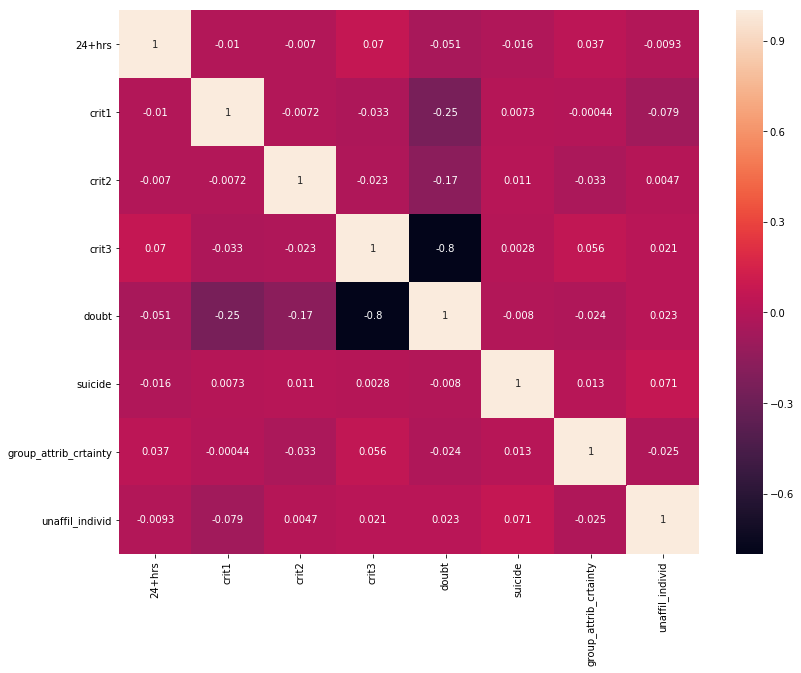

In [51]:
f, ax = plt.subplots(figsize = (13, 10))
sns.heatmap(cyber_train_input.corr(), annot = True)
plt.show()

### 3. Feature Selection:

> Getting closer to modeling and using feature selection algorithms to see what will help us best minimize our feature set while maintaining the most amount of variation in our dataset.

#### A. Select K-Best:

In [52]:
# Scouting out the null situation:

print(cyber_train_input.shape)
cyber_train_input.isna().sum()

(7114, 19)


24+hrs                     0
country_txt                0
region_txt                 0
city                      37
crit1                      0
crit2                      0
crit3                      0
doubt                      0
suicide                    0
attack_1txt                0
target_1txt                0
sub_targettxt            354
specific_target           10
victim_nationalitytxt     79
group_name                 0
group_attrib_crtainty     34
unaffil_individ            0
weapontxt                  0
sub_weapontxt            512
dtype: int64

In [53]:
print(cyber_test_input.shape)
cyber_test_input.isna().sum()

(2372, 19)


24+hrs                     0
country_txt                0
region_txt                 0
city                       9
crit1                      0
crit2                      0
crit3                      0
doubt                      0
suicide                    0
attack_1txt                0
target_1txt                0
sub_targettxt            127
specific_target            4
victim_nationalitytxt     35
group_name                 0
group_attrib_crtainty     13
unaffil_individ            0
weapontxt                  0
sub_weapontxt            159
dtype: int64

> Since the null values are relatively few, we will go ahead and drop them from the input dataframes.  This could be better than imputing the mode

##### Assessing Overall DF (cyber_train_dummy/cyber_train_output2):

In [54]:
from sklearn import feature_selection

# Getting dummies or our input train and test data:

cyber_train_dummy = pd.DataFrame(pd.get_dummies(cyber_train_input.dropna(axis = 0)))
train_dummy_index = cyber_train_dummy.index
cyber_train_output2 = pd.DataFrame(cyber_train_output[cyber_train_output.index.map(
                                                        lambda x: x in train_dummy_index)])

cyber_test_dummy = pd.DataFrame(pd.get_dummies(cyber_test_input.dropna(axis = 0)))
test_dummy_index = cyber_test_dummy.index
cyber_test_output2 = pd.DataFrame(cyber_test_output[cyber_test_output.index.map(
                                                        lambda x: x in test_dummy_index)])

In [55]:
# Making sure we have the same sizes still:

print(cyber_train_dummy.shape)
print(cyber_train_output2.shape)

print(cyber_test_dummy.shape)
print(cyber_test_output2.shape)

(6182, 7287)
(6182, 1)
(2074, 2961)
(2074, 1)


In [203]:
# Fitting SelectKBest to our Features and output:

KBest_1 = feature_selection.SelectKBest(k = 30)

KBest_1.fit_transform(cyber_train_dummy, cyber_train_output2)
KBest_1_input = KBest_1.fit_transform(cyber_train_dummy, cyber_train_output2)

In [57]:
# Creating a DF with the top 30 features:

feature_mask = KBest_1.get_support(indices = True)
KBest_1_features = pd.DataFrame(cyber_train_dummy.columns[feature_mask])

# Summarizing the scores for those top 30 features in a df:

KBest_1_features['P_Vals'] = KBest_1.pvalues_[0:30]
KBest_1_features['Scores'] = KBest_1.scores_[0:30]

print('Here is a dataframe with the top 30 features selected by this algorithm, along with\n'
       'the P-Value and ANova score of each feature: \n')
KBest_1_features

Here is a dataframe with the top 30 features selected by this algorithm, along with
the P-Value and ANova score of each feature: 



,0,P_Vals,Scores
0,24+hrs,3.975710e-12,48.328309
1,country_txt_Germany,3.828197e-01,0.761736
2,country_txt_Ireland,3.367927e-01,0.922746
3,country_txt_United Kingdom,4.803932e-05,16.547405
4,region_txt_Western Europe,1.190777e-05,19.209347
5,city_Belfast,3.145245e-01,1.011745
6,city_Dublin,6.925416e-01,0.156362
7,attack_1txt_Assassination,1.288891e-01,2.306450
8,attack_1txt_Bombing/Explosion,1.362198e-03,10.265630
9,attack_1txt_Hostage Taking (Kidnapping),1.120278e-01,2.526101


Pertinent columns:
24 hrs
country_txt / victim nationality
city
attack_1
target_1
sub_target
group_name
sub_weapon

##### Assessing Individual Features:

> Running SelectKBest on a few columns individually to see which of their values is selected as most important:  


> ###### Group_name (name_train_dummy/name_train_output2):

In [211]:
# Getting dummies or our input train and test data:

name_train_dummy = pd.DataFrame(pd.get_dummies(cyber_train_input['group_name'].dropna(axis = 0)))
name_train_dummy_index = name_train_dummy.index
name_train_output2 = pd.DataFrame(cyber_train_output[cyber_train_output.index.map(
                                                        lambda x: x in name_train_dummy_index)])

name_test_dummy = pd.DataFrame(pd.get_dummies(cyber_test_input['group_name'].dropna(axis = 0)))
name_test_dummy_index = cyber_test_dummy.index
name_test_output2 = pd.DataFrame(cyber_test_output[cyber_test_output.index.map(
                                                        lambda x: x in name_test_dummy_index)])

In [220]:
# Group_names:

KBest_names = feature_selection.SelectKBest(k = 30)
KBest_names.fit_transform(name_train_dummy, name_train_output2)
KBest_names_input = KBest_names.fit_transform(name_train_dummy, name_train_output2)

names_mask = KBest_names.get_support(indices = True)
KBest_names_features = pd.DataFrame(name_train_dummy.columns[names_mask])

# Summarizing the scores for those top 30 features in a df:

KBest_names_features['P_Vals'] = KBest_names.pvalues_[0:30]
KBest_names_features['Scores'] = KBest_names.scores_[0:30]

print('Here is a dataframe with the top 30 features selected by this algorithm, along with\n'
       'the P-Value and ANova score of each feature: \n')
KBest_names_features   

Here is a dataframe with the top 30 features selected by this algorithm, along with
the P-Value and ANova score of each feature: 



,0,P_Vals,Scores
0,African_Religious,0.653011,0.202142
1,Anti-Gun Control extremists,0.750576,0.101055
2,Armed Commandos of Liberation,0.750576,0.101055
3,Bangladesh Nationalist Party (BNP),0.750576,0.101055
4,Communist Party of India - Maoist (CPI-Maoist),0.750576,0.101055
5,Communist Party of Nepal - Maoist (CPN-Maoist-...,0.653011,0.202142
6,Communist Party of Nepal-Maoist (Baidya),0.750576,0.101055
7,Dima Halao Daoga (DHD),0.750576,0.101055
8,Hekla Reception Committee-Initiative for More ...,0.750576,0.101055
9,Hushaysh Tribal Members,0.750576,0.101055


Pertinent groups:
African - Religious
Irish
Middle_easter religious
India

> ###### City (city_train_dummy/city_train_output2):

In [60]:
# Getting dummies or our input train and test data:

city_train_dummy = pd.DataFrame(pd.get_dummies(cyber_train_input['city'].dropna(axis = 0)))
city_train_dummy_index = city_train_dummy.index
city_train_output2 = pd.DataFrame(cyber_train_output[cyber_train_output.index.map(
                                                        lambda x: x in city_train_dummy_index)])

city_test_dummy = pd.DataFrame(pd.get_dummies(cyber_test_input['city'].dropna(axis = 0)))
city_test_dummy_index = cyber_test_dummy.index
city_test_output2 = pd.DataFrame(cyber_test_output[cyber_test_output.index.map(
                                                        lambda x: x in city_test_dummy_index)])

In [213]:
# Group_city:

KBest_city = feature_selection.SelectKBest(k = 30)
KBest_city.fit_transform(city_train_dummy, city_train_output2)
KBest_city_input = KBest_city.fit_transform(city_train_dummy, city_train_output2)

city_mask = KBest_city.get_support(indices = True)
KBest_city_features = pd.DataFrame(city_train_dummy.columns[city_mask])

# Summarizing the scores for those top 30 features in a df:

KBest_city_features['P_Vals'] = KBest_city.pvalues_[0:30]
KBest_city_features['Scores'] = KBest_city.scores_[0:30]

print('Here is a dataframe with the top 30 features selected by this algorithm, along with\n'
       'the P-Value and ANova score of each feature: \n')
KBest_city_features   

Here is a dataframe with the top 30 features selected by this algorithm, along with
the P-Value and ANova score of each feature: 



,0,P_Vals,Scores
0,Aguada,0.750087,0.101466
1,Antrim,0.750087,0.101466
2,Baharak district,0.750087,0.101466
3,Belbari,0.750087,0.101466
4,Belfast,0.001690,9.866642
5,Berlin,0.750087,0.101466
6,Chukitong,0.750087,0.101466
7,Colombo,0.750087,0.101466
8,Doaba,0.473156,0.514650
9,Dublin,0.750087,0.101466


western sites/cities
ireland
Asia
Afghanistan

> ###### Weapontxt (weapon_train_dummy/weapon_train_output2):

In [62]:
# Getting dummies on our input train and test data:

weapon_train_dummy = pd.DataFrame(pd.get_dummies(cyber_train_input['weapontxt'].dropna(axis = 0)))
weapon_train_dummy_index = weapon_train_dummy.index
weapon_train_output2 = pd.DataFrame(cyber_train_output[cyber_train_output.index.map(
                                                        lambda x: x in weapon_train_dummy_index)])

weapon_test_dummy = pd.DataFrame(pd.get_dummies(cyber_test_input['weapontxt'].dropna(axis = 0)))
weapon_test_dummy_index = cyber_test_dummy.index
weapon_test_output2 = pd.DataFrame(cyber_test_output[cyber_test_output.index.map(
                                                        lambda x: x in weapon_test_dummy_index)])

In [224]:
# Group_subweapon:

KBest_weapon = feature_selection.SelectKBest(k = 7)
KBest_weapon.fit_transform(weapon_train_dummy, weapon_train_output2)
KBest_weapon_input = KBest_weapon.fit_transform(weapon_train_dummy, weapon_train_output2)

weapon_mask = KBest_weapon.get_support(indices = True)
KBest_weapon_features = pd.DataFrame(weapon_train_dummy.columns[weapon_mask])

# Summarizing the scores for those top 30 features in a df:

KBest_weapon_features['P_Vals'] = KBest_weapon.pvalues_[0:7]
KBest_weapon_features['Scores'] = KBest_weapon.scores_[0:7]

print('Here is a dataframe with the top 30 features selected by this algorithm, along with\n'
       'the P-Value and ANova score of each feature: \n')
KBest_weapon_features   

Here is a dataframe with the top 30 features selected by this algorithm, along with
the P-Value and ANova score of each feature: 



,0,P_Vals,Scores
0,Bio-Chem,1.048203e-10,41.855022
1,Explosives,8.316385e-25,106.559380
2,Fake/Other,2.248927e-02,5.209803
3,Firearms,2.156256e-08,31.419901
4,Incendiary,1.011278e-06,23.948448
5,Melee,9.027935e-06,19.735521
6,Unknown,2.338343e-01,1.417626


top 3:  
Bio-chem
Explosives
Fake/Other

#### B. Principle Component Analysis:

> ##### Assessing Overall DF (PCA_1_input):

In [225]:
from sklearn.decomposition import PCA

# Using the whole dataset (cyber_train_data):

PCA_1 = PCA(n_components = 30)
PCA_1.fit_transform(cyber_train_dummy, cyber_train_output2)
PCA_1_input = PCA_1.fit_transform(cyber_train_dummy, cyber_train_output2)

PCA_1_df = pd.DataFrame(data = PCA_1.singular_values_)
PCA_1_df['Explained_Variance'] = PCA_1.explained_variance_
PCA_1_df['Explained_Variance_Ratio'] = PCA_1.explained_variance_ratio_
PCA_1_df['Noise_Variance'] = PCA_1.noise_variance_
PCA_1_df = PCA_1_df.rename(columns = {0:'Singular_Vals'})


In [222]:
print((PCA_1_input.shape))
PCA_1_df

(6182, 30)


,Singular_Vals,Explained_Variance,Explained_Variance_Ratio,Noise_Variance
0,88.168983,1.257688,0.137018,0.000556
1,65.328270,0.690468,0.075223,0.000556
2,47.527054,0.365446,0.039813,0.000556
3,44.244200,0.316704,0.034503,0.000556
4,42.087647,0.286583,0.031222,0.000556
5,39.997513,0.258826,0.028198,0.000556
6,36.989336,0.221358,0.024116,0.000556
7,36.182471,0.211806,0.023075,0.000556
8,34.998210,0.198168,0.021589,0.000556
9,33.247258,0.178835,0.019483,0.000556


> ##### Assessing Individual Features

> ###### Group_name (PCA_names_input):

In [226]:
# Now looking at group_name stuffs:

PCA_names = PCA(n_components = 30)
PCA_names.fit_transform(name_train_dummy, name_train_output2)
PCA_names_input = PCA_names.fit_transform(name_train_dummy, name_train_output2)

PCA_names_df = pd.DataFrame(data = PCA_names.singular_values_)
PCA_names_df['Explained_Variance'] = PCA_names.explained_variance_
PCA_names_df['Explained_Variance_Ratio'] = PCA_names.explained_variance_ratio_
PCA_names_df['Noise_Variance'] = PCA_names.noise_variance_
PCA_names_df = PCA_names_df.rename(columns = {0:'Singular_Vals'})

In [128]:
print((PCA_names_input.shape))
PCA_names_df

(7114, 30)


,Singular_Vals,Explained_Variance,Explained_Variance_Ratio,Noise_Variance
0,45.165778,0.286791,0.431677,0.000263
1,25.433324,0.090940,0.136882,0.000263
2,16.241698,0.037086,0.055822,0.000263
3,12.769951,0.022926,0.034508,0.000263
4,11.776176,0.019496,0.029346,0.000263
5,10.696249,0.016085,0.024210,0.000263
6,9.988581,0.014027,0.021113,0.000263
7,9.804111,0.013513,0.020340,0.000263
8,9.667003,0.013138,0.019775,0.000263
9,8.054045,0.009120,0.013727,0.000263


> ###### City (PCA_cities_input:

In [228]:
# Then some city stuff:

PCA_cities = PCA(n_components = 30)
PCA_cities.fit_transform(city_train_dummy, city_train_output2)
PCA_cities_input = PCA_cities.fit_transform(city_train_dummy, city_train_output2)

PCA_cities_df = pd.DataFrame(PCA_cities.singular_values_)
PCA_cities_df['Explained_Variance'] = PCA_cities.explained_variance_
PCA_cities_df['Explained_Variance_Ratio'] = PCA_cities.explained_variance_ratio_
PCA_cities_df['Noise_Variance'] = PCA_cities.noise_variance_
PCA_cities_df = PCA_cities_df.rename(columns = {0:'Singular_Vals'})

In [130]:
print((PCA_cities_input.shape))
PCA_cities_df

(7077, 30)


,Singular_Vals,Explained_Variance,Explained_Variance_Ratio,Noise_Variance
0,24.117096,0.082198,0.083459,0.000209
1,19.896786,0.055947,0.056805,0.000209
2,18.147364,0.046541,0.047255,0.000209
3,11.606140,0.019037,0.019328,0.000209
4,9.765327,0.013477,0.013683,0.000209
5,8.713518,0.010730,0.010895,0.000209
6,7.391364,0.007721,0.007839,0.000209
7,7.250030,0.007428,0.007542,0.000209
8,7.101831,0.007128,0.007237,0.000209
9,6.820829,0.006575,0.006676,0.000209


> ###### Weapontxt (PCA_weapon_input):

In [229]:
# Group_subweapon:

PCA_weapon = PCA(n_components = 7)
PCA_weapon.fit_transform(weapon_train_dummy, weapon_train_output2)
PCA_weapon_input = PCA_weapon.fit_transform(weapon_train_dummy, weapon_train_output2)

# Summarizing the scores for those top 30 features in a df:

PCA_weapon_df = pd.DataFrame(PCA_weapon.singular_values_)
PCA_weapon_df['Explained_Variance'] = PCA_weapon.explained_variance_
PCA_weapon_df['Explained_Variance_Ratio'] = PCA_weapon.explained_variance_ratio_
PCA_weapon_df['Noise_Variance'] = PCA_weapon.noise_variance_ 
PCA_weapon_df = PCA_weapon_df.rename(columns = {0:'Singular_Vals'})

In [132]:
print((PCA_weapon_input.shape))
PCA_weapon_df

(7114, 7)


,Singular_Vals,Explained_Variance,Explained_Variance_Ratio,Noise_Variance
0,50.942368,0.364843,0.648064,4.511831e-29
1,27.365957,0.105285,0.187017,4.511831e-29
2,19.211077,0.051886,0.092164,4.511831e-29
3,15.911721,0.035594,0.063226,4.511831e-29
4,4.281769,0.002577,0.004578,4.511831e-29
5,3.358257,0.001586,0.002816,4.511831e-29
6,2.923972,0.001202,0.002135,4.511831e-29


#### C. Creating Specified DF with Selected Features:

> ##### DataFrame from KBest Algorithims (KBest_input):

In [232]:
main_features = cyber_train_dummy[cyber_train_dummy.columns[feature_mask]]

name_features = cyber_train_dummy[cyber_train_dummy.columns[names_mask]]

city_features = cyber_train_dummy[cyber_train_dummy.columns[city_mask]]

weapon_features = cyber_train_dummy[cyber_train_dummy.columns[weapon_mask]]

KBest_train = pd.concat([main_features, name_features, city_features, weapon_features], axis = 1)

# Dropping 24+hrs since it would be overly correlated for what we are doing here.

KBest_train = KBest_train.drop('24+hrs', axis = 1)

> ##### DataFrame from PCA (PCA_data):

In [233]:
# Trimming the last of the rows on some of our results that are too long:

PCA_1_input = pd.DataFrame(PCA_1_input)
PCA_names = pd.DataFrame(PCA_names_input[0:6182, :])
PCA_cities = pd.DataFrame(PCA_cities_input[0:6182, :])
PCA_weapon = pd.DataFrame(PCA_weapon_input[0:6182, :])

PCA_data = pd.DataFrame()
PCA_data = pd.concat([PCA_1_input, PCA_names, PCA_cities, PCA_weapon], axis = 1)

### 4. Modelling - Round 1:

> Starting with our main KBest_data and putting it into lasso regression so as to gain another perspective of feature selection (i.e. seeing which features it drops from the dataframe.

In [185]:
from sklearn.linear_model import LogisticRegression, Ridge, Lasso

lasso_1 = Lasso()

In [ ]:
# Evaluation:
    
lasso_1_confusion = confusion_matrix(y_test, regr_ypred_, labels = [0, 1])
lasso_1_cv = cross_val_score(regr_1, X_train, y_train, cv = 5)
lasso_1_train_score = regr_1.score( X_train, y_train)
lasso_1_test_score = regr_1.score( X_test, y_test)

In [ ]:
plusminus = u"\u00B1"

print("The training score is: {:.2%}".format(regr_1_train_score))
print("\nThe mean cross-validation score is: {:.2%} {}{:.2%}\n".format(regr_1_cv.mean(),
                                                                      plusminus, regr_1_cv.std()))
print("The cv scores are: \n{}".format(regr_1_cv))
print("\nThe test score is: {:.2%}".format(regr_1_test_score))

conf_df = pd.DataFrame(regr_1_confusion)

FP = conf_df.loc[0, 1]
FN = conf_df.loc[1, 0]
NegT = conf_df.iloc[0].sum()
PosT = conf_df.iloc[1].sum()

print(conf_df)

print('False Positive (Type I Error): {}\n({:.2%})\n'.format(FP, (FP / NegT)))
print('False Negative (Type II Error): {}\n({:.2%})\n'.format(FN, (FN / PosT)))
